<a href="https://colab.research.google.com/github/ABD-01/Siamese-Triplet/blob/master/Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision
import torchvision.transforms as transforms

In [2]:
import sklearn
from sklearn import datasets

In [3]:
lfw_pairs = datasets.fetch_lfw_pairs(
    subset='train',
    data_home="/content/drive/MyDrive/Colab Notebooks/lfw",
    funneled=False,
    resize=1,
    color=True,
    # download_if_missing=True
    )
# ref : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_pairs.html

In [4]:
lfw_pairs.keys()

dict_keys(['data', 'pairs', 'target', 'target_names', 'DESCR'])

In [5]:
pairDevTrain = open("/content/drive/MyDrive/Colab Notebooks/lfw/lfw_home/pairsDevTrain.txt").readlines()[1:]

Nicolas_Lapentti	1	Paula_Dobriansky	1

Different persons


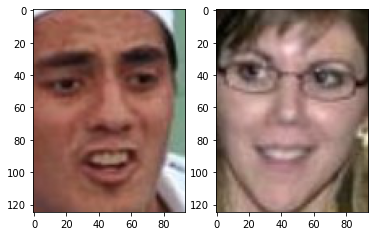

In [12]:
index = 2109
_, axxar = plt.subplots(1,2)
axxar[0].imshow(lfw_pairs.pairs[index][0] / 255)
axxar[1].imshow(lfw_pairs.pairs[index][1] / 255)
print(pairDevTrain[index])
print(lfw_pairs.target_names[lfw_pairs.target[index]])

In [6]:
lfw_people = datasets.fetch_lfw_people(
    data_home="/content/drive/MyDrive/Colab Notebooks/LFW",
    min_faces_per_person=2,
    resize=1,
    color=True,
    # download_if_missing=True
)

In [14]:
lfw_people.data.shape

(9164, 35250)

In [15]:
lfw_people.images.shape

(9164, 125, 94, 3)

In [16]:
np.moveaxis(lfw_people.images, -1,-3).shape

(9164, 3, 125, 94)

In [17]:
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [18]:
lfw_people.target[46]# .shape

1482

'Anthony Hopkins'

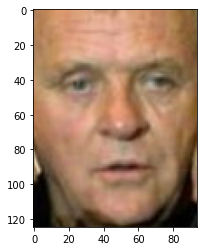

In [19]:
plt.imshow(lfw_people.images[5] / 255)
lfw_people.target_names[lfw_people.target[5]]

In [20]:
randomstate = np.random.RandomState(seed=None)

In [21]:
no_of_classes = len(lfw_people.target_names)

In [ ]:
pos_class = randomstate.choice(no_of_classes)
neg_class = randomstate.choice(no_of_classes)
while pos_class == neg_class:
    neg_class = randomstate.choice(classes_per_batch)
pos_class, neg_class

(928, 281)

In [ ]:
pos_name = lfw_people.target_names[pos_class]
neg_name = lfw_people.target_names[neg_class]
pos_name, neg_name

('Larry Lucchino', 'Christian Wulff')

In [ ]:
pos_imgs = lfw_people.images[lfw_people.target == pos_class]
neg_imgs = lfw_people.images[lfw_people.target == neg_class]
pos_imgs.shape[0], neg_imgs.shape[0]

(2, 2)

In [ ]:
if pos_imgs.shape[0] == 2:
    ianc, ipos = 0,1
else:
    ianc = randomstate.randint(0, pos_imgs.shape[0])
    ipos = randomstate.randint(0, pos_imgs.shape[0])
    while ianc == ipos:
        ipos = randomstate.randint(0, len(face_classes[pos_class]))

In [ ]:
ineg = randomstate.randint(0, neg_imgs.shape[0])

In [ ]:
ianc

0

In [ ]:

# Ref : https://github.com/tamerthamoqa/facenet-pytorch-vggface2/blob/master/datasets/TripletLossDataset.py#L76-L136

Pos_class : Larry Lucchino, Neg_class : 281


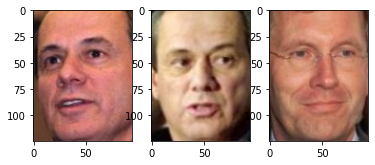

In [ ]:
_,axxar = plt.subplots(1,3)
axxar[0].imshow(pos_imgs[ianc] / 255)
axxar[1].imshow(pos_imgs[ipos] / 255)
axxar[2].imshow(neg_imgs[ineg] / 255)
print(f'Pos_class : {pos_name}, Neg_class : {neg_class}')

In [ ]:
lfw_people.target_names[928]

'Larry Lucchino'

In [ ]:
triplets = []

In [7]:
def get_random_triplets(no_classes:int, images, target, no_triplets:int):
    # Ref : https://github.com/tamerthamoqa/facenet-pytorch-vggface2/blob/master/datasets/TripletLossDataset.py#L76-L136
    randomstate = np.random.RandomState(seed=None)
    # no_class = len(lfw_people.target_names)
    triplets = []
    class_pairs = []

    ###
    # _,axxar = plt.subplots(no_triplets,3, figsize=(7,5))
    # plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    # # ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
    ###

    progress_bar = tqdm(range(no_triplets), desc='fetching triplets')
    for progress in progress_bar:

        pos_class = randomstate.choice(no_classes)
        neg_class = randomstate.choice(no_classes)
        while pos_class == neg_class:
            neg_class = randomstate.choice(no_classes)

        # pos_name = lfw_people.target_names[pos_class]
        # neg_name = lfw_people.target_names[neg_class]

        pos_imgs = images[target == pos_class]
        neg_imgs = images[target == neg_class]

        if pos_imgs.shape[0] == 2:
            ianc, ipos = 0,1
        else:
            ianc = randomstate.randint(0, pos_imgs.shape[0])
            ipos = randomstate.randint(0, pos_imgs.shape[0])
            while ianc == ipos:
                ipos = randomstate.randint(0, pos_imgs.shape[0])
        ineg = randomstate.randint(0, neg_imgs.shape[0])

        ####
        # axxar[progress][0].imshow(pos_imgs[ianc] / 255)
        # axxar[progress][0].set_title(lfw_people.target_names[pos_class])
        # axxar[progress][1].imshow(pos_imgs[ipos] / 255)
        # axxar[progress][1].set_title(lfw_people.target_names[pos_class])
        # axxar[progress][2].imshow(neg_imgs[ineg] / 255)
        # axxar[progress][2].set_title(lfw_people.target_names[neg_class])
        ####

        triplets.append(
            torch.stack([
                torch.from_numpy(pos_imgs[ianc]), 
                torch.from_numpy(pos_imgs[ipos]), 
                torch.from_numpy(neg_imgs[ineg])
            ]))
        class_pairs.append((pos_class, neg_class))

    return torch.stack(triplets) , class_pairs

fetching triplets: 100%|██████████| 5/5 [00:00<00:00, 187.59it/s]


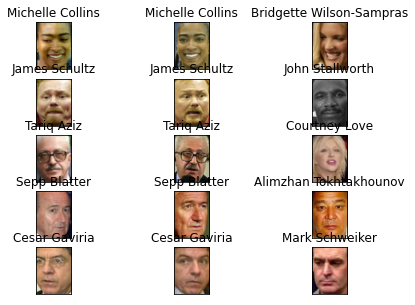

In [23]:
triplets, class_pairs = get_random_triplets(no_classes=len(lfw_people.target_names), images=lfw_people.images, target=lfw_people.target, no_triplets=5)

Text(0.5, 1.0, 'hello')

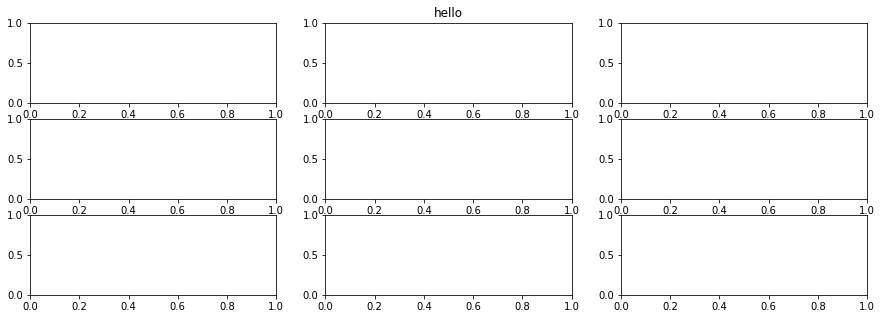

In [ ]:
_,axxar = plt.subplots(3,3, figsize = (15,5))
axxar[0,1].set_title('hello')

In [ ]:
triplets.shape

torch.Size([3, 3, 125, 94, 3])

In [ ]:
triplets.shape

torch.Size([3, 3, 125, 94, 3])

# Model

In [101]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.convnet1 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7,5))),
                            ('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5))),
                            ('norm', nn.BatchNorm2d(32)),
                            ('relu', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        # ref : https://discuss.pytorch.org/t/is-it-possible-to-specify-a-name-for-each-layer-when-creating-the-model/33637/2

        self.convnet2 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(64)),
                            ('relu', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.convnet3 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(128)),
                            ('relu', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.FCs      = nn.Sequential(OrderedDict([
                            ('FC1', nn.Linear(in_features=7680, out_features=2048)),
                            ('relu1', nn.ReLU(inplace=True)),
                            ('FC2', nn.Linear(in_features=2048, out_features=512)),
                            ('relu2', nn.ReLU(inplace=True)),
                            ('FC3', nn.Linear(in_features=512, out_features=128)),
                            ('relu3', nn.ReLU(inplace=True)),
        ]))

        # self.out      = nn.Linear(in_features=128, out_features=2)

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')  # He-initialization
                # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

    def semi_forward(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        # x = x.view(-1, 10*6*128)
        x = x.reshape(-1, 10*6*128)
        x = self.FCs(x)
        return x

    def forward(self,triplet):
        triplet = triplet.movedim(-1, -3)
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

In [27]:
x = torch.rand(3, 3, 125, 94, 3)
print(x.shape)
x = x.movedim(-1, -3)
print(x.shape)
print(x[:,0,...].shape)
x = model.convnet1(x[:,0,...])
print(x.shape)
x = model.convnet2(x)
print(x.shape)
x = model.convnet3(x)
print(x.shape)
x = x.view(-1, 10*6*128)
print(x.shape)
x = model.FCs(x)
print(x.shape)
print()
x = torch.rand(3, 3, 125, 94, 3)
# x = x.movedim(-1, -3)
x = model(x)
print(x[0].shape)

torch.Size([3, 3, 125, 94, 3])
torch.Size([3, 3, 3, 125, 94])
torch.Size([3, 3, 125, 94])
torch.Size([3, 32, 57, 42])
torch.Size([3, 64, 26, 18])
torch.Size([3, 128, 10, 6])
torch.Size([3, 7680])
torch.Size([3, 128])

torch.Size([3, 128])


In [ ]:
type(x)

list

In [ ]:
triplet_loss(*x)

tensor(0.1944, grad_fn=<MeanBackward0>)

In [9]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(7, 5), stride=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FCs): Sequential(
    (FC1): Linear(in_features=7680, out_features=2048, bias=True)
    (relu1): ReLU(inplace=True)
    (FC2): Linear(in_features=2048, out_features=5

In [ ]:
lfw_pairs.pairs[:1100].shape

(1100, 2, 125, 94, 3)

In [ ]:
lfw_pairs.pairs[1100:, 0].shape

(1100, 125, 94, 3)

In [161]:
def triplet_loss(anchor, positive, negative, margin=1):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [162]:
model = Model().cuda()
learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
lossfn = nn.TripletMarginLoss(margin=0.2, reduction='mean')

In [163]:
lfw_people.images.shape

(9164, 125, 94, 3)

In [164]:
del triplets

In [165]:
cost = []

epochs = 10
for epoch in range(epochs):

    triplets, class_pairs = get_random_triplets(no_classes=len(lfw_people.target_names),
                                                images=lfw_people.images, 
                                                target=lfw_people.target, no_triplets=100)

    apn = model(triplets.cuda())
    # apn = model(triplets)

    optimizer.zero_grad()
    loss = triplet_loss(*apn)
    # loss = lossfn(*apn)
    cost.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}\n')


fetching triplets: 100%|██████████| 100/100 [00:00<00:00, 1396.24it/s]

Epoch:[1/10] , Cost : 0.9061514139175415




fetching triplets: 100%|██████████| 100/100 [00:00<00:00, 1607.57it/s]

Epoch:[2/10] , Cost : 24.585737228393555




fetching triplets: 100%|██████████| 100/100 [00:00<00:00, 1571.25it/s]

Epoch:[3/10] , Cost : 1.5386483669281006




fetching triplets: 100%|██████████| 100/100 [00:00<00:00, 1304.45it/s]

Epoch:[4/10] , Cost : 1.0936204195022583




fetching triplets: 100%|██████████| 100/100 [00:00<00:00, 1208.39it/s]

Epoch:[5/10] , Cost : 1.0363655090332031




fetching triplets: 100%|██████████| 100/100 [00:00<00:00, 1510.76it/s]

Epoch:[6/10] , Cost : 0.8814986348152161




fetching triplets: 100%|██████████| 100/100 [00:00<00:00, 953.08it/s]

Epoch:[7/10] , Cost : 0.8074883818626404




fetching triplets: 100%|██████████| 100/100 [00:00<00:00, 1248.19it/s]

Epoch:[8/10] , Cost : 0.9163216948509216




fetching triplets: 100%|██████████| 100/100 [00:00<00:00, 1162.95it/s]

Epoch:[9/10] , Cost : 0.7814361453056335



Epoch:[10/10] , Cost : 0.9384975433349609



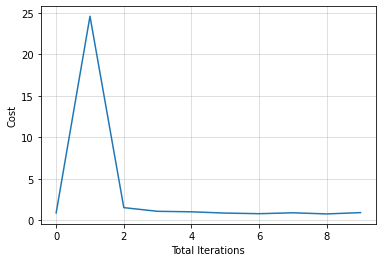

In [167]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(epochs), cost)
plt.grid(alpha=0.5)
plt.show()

In [173]:
apn[0].max()

tensor(4.3499, device='cuda:0', grad_fn=<MaxBackward1>)

In [169]:
p = (apn[0] - apn[1]).pow(2).sum(-1)
p

tensor([0.0956, 0.3611, 1.1517, 0.1418, 0.8453, 0.8091, 1.4432, 1.6893, 0.8169,
        1.4025, 3.9216, 0.2000, 0.3796, 0.4298, 1.4168, 1.1817, 2.0378, 0.8399,
        1.5801, 0.2673, 0.2660, 0.5017, 1.4567, 0.3159, 0.0933, 1.1759, 1.5221,
        2.1388, 0.5939, 0.3773, 0.4409, 0.3520, 0.1237, 3.0513, 0.7740, 0.4002,
        0.2883, 0.5799, 0.5506, 1.1433, 0.3044, 2.7993, 0.4646, 1.1645, 0.7015,
        1.0853, 3.1494, 0.1978, 0.7673, 0.3900, 1.4168, 4.7361, 0.0679, 0.4298,
        1.1276, 0.0376, 1.7764, 0.4761, 0.2704, 0.9646, 3.1954, 0.9310, 4.4678,
        0.6525, 0.4627, 1.1338, 3.1994, 2.1269, 0.1124, 0.4573, 1.0078, 0.4812,
        0.2660, 0.3913, 0.4432, 0.5950, 0.2896, 0.9320, 2.6595, 0.0520, 0.7511,
        0.2811, 0.6091, 3.2768, 0.2069, 0.1595, 2.8518, 1.3461, 2.4096, 0.9345,
        0.2584, 1.1555, 0.2053, 0.2481, 2.5118, 2.9954, 1.1625, 0.4365, 4.2522,
        1.0669], device='cuda:0', grad_fn=<SumBackward1>)

In [170]:
n = (apn[0] - apn[2]).pow(2).sum(-1)
n

tensor([3.6789, 3.2686, 2.3729, 3.1181, 1.7000, 0.9240, 1.5491, 1.5082, 1.6687,
        1.3761, 0.9001, 0.5854, 3.3099, 0.4934, 0.8519, 0.2153, 2.5606, 2.0981,
        3.3952, 1.1535, 0.1902, 0.2718, 0.7682, 0.8375, 2.5721, 0.5020, 1.5445,
        0.1762, 1.7882, 0.8138, 0.6529, 0.8198, 1.7555, 3.6522, 1.1779, 0.1677,
        1.4036, 1.9293, 0.8465, 3.5978, 1.3734, 2.5024, 0.7515, 1.9876, 0.6615,
        0.2560, 0.6168, 1.3891, 1.9500, 1.7062, 0.5521, 1.1406, 0.4657, 0.1313,
        1.7426, 2.5166, 1.7855, 2.4296, 1.1674, 1.0713, 1.1186, 0.6903, 0.5773,
        5.3116, 2.4350, 1.7444, 0.6492, 1.0903, 1.4116, 0.1894, 2.6160, 0.6826,
        0.2897, 0.2425, 0.9276, 1.1801, 5.3349, 2.1531, 1.7285, 4.9269, 1.0576,
        2.0726, 0.1950, 1.0781, 0.8003, 0.7768, 1.4502, 1.4507, 3.8061, 0.3064,
        1.0277, 1.5866, 0.3705, 1.0543, 1.2767, 1.5507, 1.0676, 2.6556, 2.2888,
        0.2402], device='cuda:0', grad_fn=<SumBackward1>)

In [160]:
(p-n).std()

tensor(0.4146, device='cuda:0', grad_fn=<StdBackward0>)

In [137]:
(F.relu(p-n + 0.2)).mean()

tensor(0.3086, grad_fn=<MeanBackward0>)

In [ ]:
model.load_state_dict(torch.load(PATH))
model.eval()

In [19]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1)

In [153]:
index = 1444
test1 = torch.from_numpy(lfw_pairs.pairs[index][0]).cuda()
test2 = torch.from_numpy(lfw_pairs.pairs[index][1]).cuda()
enc1 = model.semi_forward(test1.movedim(-1,-3).unsqueeze(0))
enc2 = model.semi_forward(test2.movedim(-1,-3).unsqueeze(0))
d = dist(enc1,enc2)
print(d)
print('Differen Person') if d > 0.5 else print('Same Person')

tensor([0.1571], device='cuda:0', grad_fn=<SumBackward1>)
Same Person


Ciro_Gomes	4	Edgar_Savisaar	1

Different persons


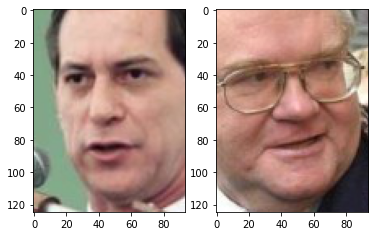

In [154]:
# Testing
# index = 3
_, axxar = plt.subplots(1,2)
axxar[0].imshow(lfw_pairs.pairs[index][0] / 255)
axxar[1].imshow(lfw_pairs.pairs[index][1] / 255)
print(pairDevTrain[index])
print(lfw_pairs.target_names[lfw_pairs.target[index]])

In [16]:
a = next(iter(LOADER))

In [17]:
a.shape

torch.Size([10, 2, 125, 94, 3])

In [23]:
model = model.cuda()

In [112]:
!nvidia-smi

Tue Feb  9 13:19:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    74W / 149W |  11348MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [114]:
torch.cuda.empty_cache()

In [76]:
torch.cuda.reset_max_memory_allocated()

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


In [11]:
# Saving the state_dict of Model
PATH = '/content/drive/MyDrive/Colab Notebooks/siamese'

In [152]:
# torch.save(model.state_dict(), PATH)

In [153]:
ColabCode(port=100, password='12345')

## .

In [ ]:
!pip install torchviz

     |████████████████████████████████| 51kB 7.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=ec58767d618243e986be401fd4ad7f2f847e329e53c26d5a9e189caa732dbc32
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


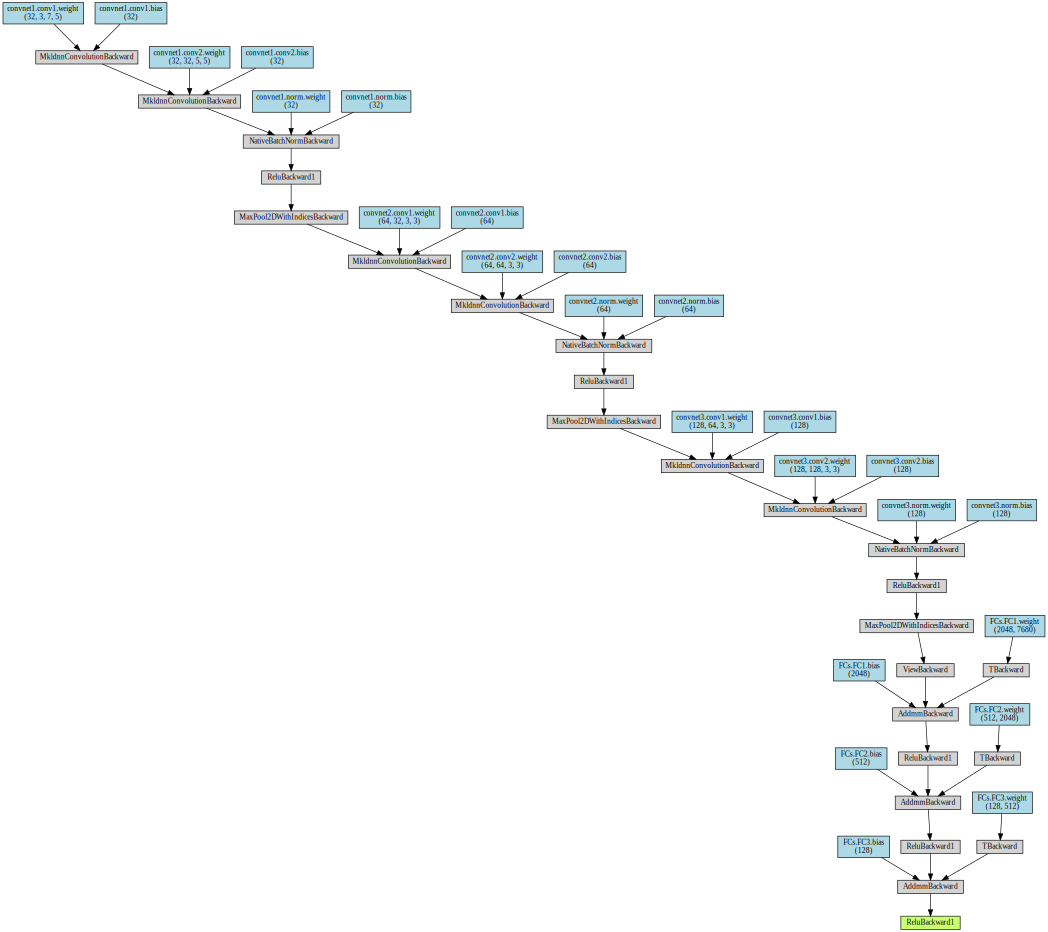

In [ ]:
from torchviz import make_dot

x = torch.randn(10,3,125,94)

make_dot(model(x), params=dict(model.named_parameters()))   

# ref : https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb

In [ ]:
!pip install git+https://github.com/waleedka/hiddenlayer.git

  Cloning https://github.com/waleedka/hiddenlayer.git to /tmp/pip-req-build-p_6ry_vw
  Running command git clone -q https://github.com/waleedka/hiddenlayer.git /tmp/pip-req-build-p_6ry_vw
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-cp36-none-any.whl size=19771 sha256=6e617219ef97172c7c0ebabb961e1921e232a97f2ff82f92e7c6fa61d14bb0d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-1mfd7y6p/wheels/49/bc/d1/938073704abdd049b3e4cdc6811c8f468d69fb5eecc6e01748
Successfully built hiddenlayer


/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


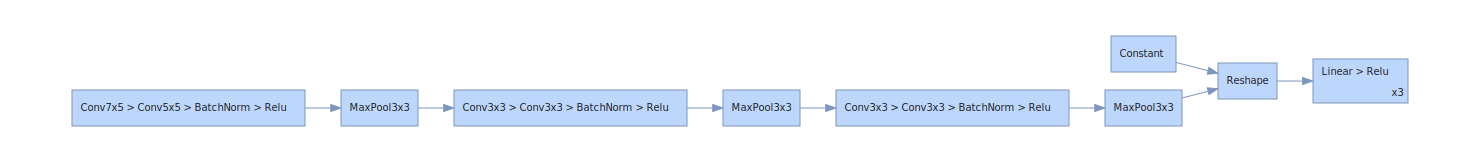

In [ ]:
import hiddenlayer as hl

# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([10,3,125,94]))

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

#ref : https://github.com/waleedka/hiddenlayer/blob/master/demos/pytorch_graph.ipynb

## .

# TensorFlow

In [ ]:
import tensorflow as tf